In [4]:
import os
import json
import pickle
import sys
sys.path.insert(0, '../')
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import DynamicSystemAnalyzer
from src.PerformanceAnalyzer import PerformanceAnalyzer
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.Task import TaskBlockDMtanh
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import PCA
from pathlib import Path
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from scipy.stats import zscore
import pandas as pd
from sklearn.metrics import adjusted_rand_score as ARI
import warnings
warnings.filterwarnings("ignore")
from rnn_coach.src.utils import get_colormaps
import numpy as np
np.set_printoptions(suppress = True)
import json
colors, cmp = get_colormaps()
projects_folder = str(Path.home()) + "/Documents/GitHub/"

In [6]:
disp = True
activation = "tanh"
taskname = "BlockDM"
train_config_file = f"train_config_{taskname}_{activation}.json"
config_dict = json.load(open(os.path.join(projects_folder, 'rnn_coach', "data", "configs", train_config_file), mode="r"))

In [7]:
# defining RNN:
N = config_dict["N"]
activation_name = config_dict["activation"]
if activation_name == 'relu':
    activation = lambda x: torch.maximum(x, torch.tensor(0))
elif activation_name == 'tanh':
    activation = torch.tanh
elif activation_name == 'sigmoid':
    activation = lambda x: 1/(1 + torch.exp(-x))
elif activation_name == 'softplus':
    activation = lambda x: torch.log(1 + torch.exp(5 * x))

dt = config_dict["dt"]
tau = config_dict["tau"]
constrained = config_dict["constrained"]
connectivity_density_rec = config_dict["connectivity_density_rec"]
spectral_rad = config_dict["sr"]
sigma_inp = config_dict["sigma_inp"]
sigma_rec = config_dict["sigma_rec"]
seed = config_dict["seed"]
rng = torch.Generator()
if not seed is None:
    rng.manual_seed(seed)
input_size = config_dict["num_inputs"]
output_size = config_dict["num_outputs"]

In [8]:
# Task:
n_steps = config_dict["n_steps"]
task_params = config_dict["task_params"]

In [9]:
# Trainer:
lambda_orth = config_dict["lambda_orth"]
lambda_r = config_dict["lambda_r"]
mask = np.array(config_dict["mask"])
max_iter = config_dict["max_iter"]
tol = config_dict["tol"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
same_batch = config_dict["same_batch"]

In [10]:
# General:
timestr = time.strftime("%Y%m%d-%H%M%S")
data_folder = os.path.join(config_dict["data_folder"], timestr)

In [12]:
# # creating instances:
rnn_torch = RNN_torch(N=N, dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                      activation=activation, constrained=constrained,
                      sigma_inp=sigma_inp, sigma_rec=sigma_rec,
                      connectivity_density_rec=connectivity_density_rec,
                      spectral_rad=spectral_rad,
                      random_generator=rng)
task = TaskBlockDMtanh(n_steps=n_steps, task_params=task_params)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_torch.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)
trainer = Trainer(RNN=rnn_torch, Task=task,
                  max_iter=max_iter, tol=tol,
                  optimizer=optimizer, criterion=criterion,
                  lambda_orth=lambda_orth, lambda_r=lambda_r)
datasaver = None

Using cpu for RNN!


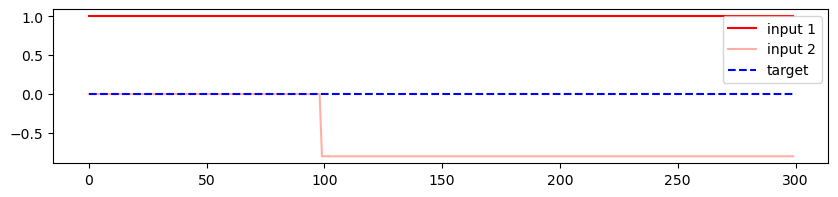

In [13]:
inputs, targets, conditions = task.get_batch()
ind = 0

fig = plt.figure(figsize = (10, 2))
plt.plot(inputs[0, :, ind], color = 'red', label = 'input 1')
plt.plot(inputs[1, :, ind], color = 'tomato', alpha = 0.5, label = 'input 2')
plt.plot(targets[0, :, ind], color = 'blue', linestyle = '--', label = 'target')
plt.legend()
plt.show()

In [9]:
# rnn_trained, train_losses, val_losses, net_params = trainer.run_training(train_mask=mask, same_batch=same_batch)

iteration 0, train loss: 0.809197, validation loss: 0.768493
iteration 1, train loss: 0.785633, validation loss: 0.743749
iteration 2, train loss: 0.753524, validation loss: 0.721496
iteration 3, train loss: 0.723837, validation loss: 0.701928
iteration 4, train loss: 0.707101, validation loss: 0.684625
iteration 5, train loss: 0.712637, validation loss: 0.671009
iteration 6, train loss: 0.68706, validation loss: 0.659759
iteration 7, train loss: 0.718016, validation loss: 0.651576
iteration 8, train loss: 0.663114, validation loss: 0.643696
iteration 9, train loss: 0.650236, validation loss: 0.635863
iteration 10, train loss: 0.657081, validation loss: 0.628797
iteration 11, train loss: 0.643534, validation loss: 0.622098
iteration 12, train loss: 0.628433, validation loss: 0.615593
iteration 13, train loss: 0.625758, validation loss: 0.609424
iteration 14, train loss: 0.598877, validation loss: 0.603597
iteration 15, train loss: 0.61026, validation loss: 0.598107
iteration 16, train 

iteration 110, train loss: 0.202395, validation loss: 0.185488
iteration 111, train loss: 0.205577, validation loss: 0.185627
iteration 112, train loss: 0.206804, validation loss: 0.185662
iteration 113, train loss: 0.205738, validation loss: 0.185622
iteration 114, train loss: 0.186682, validation loss: 0.185586
iteration 115, train loss: 0.208654, validation loss: 0.185547
iteration 116, train loss: 0.214284, validation loss: 0.185491
iteration 117, train loss: 0.193016, validation loss: 0.185158
iteration 118, train loss: 0.196573, validation loss: 0.18472
iteration 119, train loss: 0.196218, validation loss: 0.184121
iteration 120, train loss: 0.213422, validation loss: 0.183731
iteration 121, train loss: 0.187186, validation loss: 0.182963
iteration 122, train loss: 0.192551, validation loss: 0.181863
iteration 123, train loss: 0.20117, validation loss: 0.180519
iteration 124, train loss: 0.187157, validation loss: 0.178916
iteration 125, train loss: 0.200752, validation loss: 0.1

iteration 236, train loss: 0.132996, validation loss: 0.106023
iteration 237, train loss: 0.162701, validation loss: 0.10523
iteration 238, train loss: 0.134234, validation loss: 0.104564
iteration 239, train loss: 0.116428, validation loss: 0.104112
iteration 240, train loss: 0.141227, validation loss: 0.103512
iteration 241, train loss: 0.12026, validation loss: 0.102211
iteration 242, train loss: 0.158848, validation loss: 0.102878
iteration 243, train loss: 0.138934, validation loss: 0.104631
iteration 244, train loss: 0.130274, validation loss: 0.105896
iteration 245, train loss: 0.134603, validation loss: 0.106467
iteration 246, train loss: 0.158304, validation loss: 0.108159
iteration 247, train loss: 0.13292, validation loss: 0.109799
iteration 248, train loss: 0.1622, validation loss: 0.111138
iteration 249, train loss: 0.139783, validation loss: 0.111629
iteration 250, train loss: 0.140566, validation loss: 0.112032
iteration 251, train loss: 0.135093, validation loss: 0.1121

iteration 367, train loss: 0.125641, validation loss: 0.096784
iteration 368, train loss: 0.14744, validation loss: 0.097229
iteration 369, train loss: 0.178843, validation loss: 0.098474
iteration 370, train loss: 0.1529, validation loss: 0.099747
iteration 371, train loss: 0.165735, validation loss: 0.102126
iteration 372, train loss: 0.160768, validation loss: 0.105221
iteration 373, train loss: 0.142985, validation loss: 0.108188
iteration 374, train loss: 0.118385, validation loss: 0.10975
iteration 375, train loss: 0.143477, validation loss: 0.110641
iteration 376, train loss: 0.13803, validation loss: 0.111075
iteration 377, train loss: 0.147214, validation loss: 0.111457
iteration 378, train loss: 0.148064, validation loss: 0.111163
iteration 379, train loss: 0.140622, validation loss: 0.110855
iteration 380, train loss: 0.133718, validation loss: 0.109616
iteration 381, train loss: 0.139153, validation loss: 0.107945
iteration 382, train loss: 0.167253, validation loss: 0.1072

iteration 497, train loss: 0.146183, validation loss: 0.097118
iteration 498, train loss: 0.11273, validation loss: 0.098614
iteration 499, train loss: 0.103597, validation loss: 0.099647
iteration 500, train loss: 0.153603, validation loss: 0.100364
iteration 501, train loss: 0.114302, validation loss: 0.100473
iteration 502, train loss: 0.124185, validation loss: 0.100318
iteration 503, train loss: 0.133155, validation loss: 0.099812
iteration 504, train loss: 0.140947, validation loss: 0.099116
iteration 505, train loss: 0.124936, validation loss: 0.098049
iteration 506, train loss: 0.111048, validation loss: 0.097035
iteration 507, train loss: 0.132472, validation loss: 0.095942
iteration 508, train loss: 0.117564, validation loss: 0.09442
iteration 509, train loss: 0.133857, validation loss: 0.092609
iteration 510, train loss: 0.140495, validation loss: 0.090578
iteration 511, train loss: 0.145939, validation loss: 0.090364
iteration 512, train loss: 0.134856, validation loss: 0.0

iteration 627, train loss: 0.094779, validation loss: 0.080293
iteration 628, train loss: 0.125697, validation loss: 0.081057
iteration 629, train loss: 0.103979, validation loss: 0.081843
iteration 630, train loss: 0.136977, validation loss: 0.083314
iteration 631, train loss: 0.131056, validation loss: 0.084968
iteration 632, train loss: 0.121537, validation loss: 0.086672
iteration 633, train loss: 0.134827, validation loss: 0.08789
iteration 634, train loss: 0.090792, validation loss: 0.08804
iteration 635, train loss: 0.127606, validation loss: 0.087629
iteration 636, train loss: 0.13189, validation loss: 0.087623
iteration 637, train loss: 0.128152, validation loss: 0.087626
iteration 638, train loss: 0.138516, validation loss: 0.088664
iteration 639, train loss: 0.1253, validation loss: 0.090542
iteration 640, train loss: 0.128024, validation loss: 0.092235
iteration 641, train loss: 0.104426, validation loss: 0.093214
iteration 642, train loss: 0.130245, validation loss: 0.0938

iteration 757, train loss: 0.148802, validation loss: 0.093965
iteration 758, train loss: 0.125453, validation loss: 0.093107
iteration 759, train loss: 0.133693, validation loss: 0.092368
iteration 760, train loss: 0.10676, validation loss: 0.091237
iteration 761, train loss: 0.106884, validation loss: 0.08923
iteration 762, train loss: 0.125705, validation loss: 0.087021
iteration 763, train loss: 0.135814, validation loss: 0.085442
iteration 764, train loss: 0.12661, validation loss: 0.083806
iteration 765, train loss: 0.10898, validation loss: 0.081614
iteration 766, train loss: 0.134894, validation loss: 0.080362
iteration 767, train loss: 0.099491, validation loss: 0.0789
iteration 768, train loss: 0.125288, validation loss: 0.077512
iteration 769, train loss: 0.134685, validation loss: 0.076118
iteration 770, train loss: 0.126574, validation loss: 0.075272
iteration 771, train loss: 0.12003, validation loss: 0.075616
iteration 772, train loss: 0.162455, validation loss: 0.077768

iteration 889, train loss: 0.124219, validation loss: 0.083146
iteration 890, train loss: 0.139573, validation loss: 0.083645
iteration 891, train loss: 0.09337, validation loss: 0.083269
iteration 892, train loss: 0.124149, validation loss: 0.08278
iteration 893, train loss: 0.126754, validation loss: 0.081981
iteration 894, train loss: 0.112744, validation loss: 0.082094
iteration 895, train loss: 0.096445, validation loss: 0.081813
iteration 896, train loss: 0.138909, validation loss: 0.081976
iteration 897, train loss: 0.109358, validation loss: 0.081554
iteration 898, train loss: 0.136772, validation loss: 0.080529
iteration 899, train loss: 0.127053, validation loss: 0.079771
iteration 900, train loss: 0.116957, validation loss: 0.078857
iteration 901, train loss: 0.105749, validation loss: 0.078152
iteration 902, train loss: 0.117503, validation loss: 0.077771
iteration 903, train loss: 0.159803, validation loss: 0.079305
iteration 904, train loss: 0.141933, validation loss: 0.0

iteration 1019, train loss: 0.123557, validation loss: 0.079176
iteration 1020, train loss: 0.135636, validation loss: 0.078261
iteration 1021, train loss: 0.11768, validation loss: 0.078344
iteration 1022, train loss: 0.148156, validation loss: 0.079396
iteration 1023, train loss: 0.136616, validation loss: 0.08106
iteration 1024, train loss: 0.105816, validation loss: 0.081686
iteration 1025, train loss: 0.103319, validation loss: 0.081664
iteration 1026, train loss: 0.128339, validation loss: 0.081134
iteration 1027, train loss: 0.127466, validation loss: 0.081467
iteration 1028, train loss: 0.106305, validation loss: 0.081054
iteration 1029, train loss: 0.130368, validation loss: 0.081247
iteration 1030, train loss: 0.12761, validation loss: 0.080712
iteration 1031, train loss: 0.144088, validation loss: 0.079497
iteration 1032, train loss: 0.132243, validation loss: 0.078928
iteration 1033, train loss: 0.07486, validation loss: 0.077652
iteration 1034, train loss: 0.098873, valida

iteration 1147, train loss: 0.108, validation loss: 0.088461
iteration 1148, train loss: 0.116611, validation loss: 0.088108
iteration 1149, train loss: 0.106032, validation loss: 0.087457
iteration 1150, train loss: 0.116669, validation loss: 0.086432
iteration 1151, train loss: 0.163588, validation loss: 0.085696
iteration 1152, train loss: 0.149519, validation loss: 0.085375
iteration 1153, train loss: 0.129147, validation loss: 0.085206
iteration 1154, train loss: 0.108916, validation loss: 0.0839
iteration 1155, train loss: 0.135302, validation loss: 0.082969
iteration 1156, train loss: 0.099373, validation loss: 0.08168
iteration 1157, train loss: 0.107033, validation loss: 0.080394
iteration 1158, train loss: 0.126266, validation loss: 0.078877
iteration 1159, train loss: 0.118374, validation loss: 0.077147
iteration 1160, train loss: 0.1462, validation loss: 0.076089
iteration 1161, train loss: 0.109869, validation loss: 0.075481
iteration 1162, train loss: 0.098905, validation

iteration 1275, train loss: 0.118104, validation loss: 0.076393
iteration 1276, train loss: 0.111762, validation loss: 0.074846
iteration 1277, train loss: 0.120779, validation loss: 0.073531
iteration 1278, train loss: 0.097629, validation loss: 0.072717
iteration 1279, train loss: 0.123613, validation loss: 0.072357
iteration 1280, train loss: 0.137732, validation loss: 0.071435
iteration 1281, train loss: 0.100684, validation loss: 0.071352
iteration 1282, train loss: 0.134434, validation loss: 0.071461
iteration 1283, train loss: 0.097068, validation loss: 0.070882
iteration 1284, train loss: 0.113084, validation loss: 0.070254
iteration 1285, train loss: 0.146214, validation loss: 0.07078
iteration 1286, train loss: 0.129212, validation loss: 0.071857
iteration 1287, train loss: 0.168947, validation loss: 0.073856
iteration 1288, train loss: 0.097584, validation loss: 0.075211
iteration 1289, train loss: 0.117191, validation loss: 0.076338
iteration 1290, train loss: 0.138421, val

iteration 1405, train loss: 0.117272, validation loss: 0.065551
iteration 1406, train loss: 0.094889, validation loss: 0.065053
iteration 1407, train loss: 0.141267, validation loss: 0.065303
iteration 1408, train loss: 0.123928, validation loss: 0.066459
iteration 1409, train loss: 0.141613, validation loss: 0.06764
iteration 1410, train loss: 0.116743, validation loss: 0.069509
iteration 1411, train loss: 0.108803, validation loss: 0.071686
iteration 1412, train loss: 0.147705, validation loss: 0.074948
iteration 1413, train loss: 0.135347, validation loss: 0.078772
iteration 1414, train loss: 0.122942, validation loss: 0.081914
iteration 1415, train loss: 0.11037, validation loss: 0.083972
iteration 1416, train loss: 0.117446, validation loss: 0.085419
iteration 1417, train loss: 0.123721, validation loss: 0.087069
iteration 1418, train loss: 0.129467, validation loss: 0.088653
iteration 1419, train loss: 0.12787, validation loss: 0.089807
iteration 1420, train loss: 0.116296, valid

iteration 1535, train loss: 0.121784, validation loss: 0.067331
iteration 1536, train loss: 0.087679, validation loss: 0.06548
iteration 1537, train loss: 0.092585, validation loss: 0.064486
iteration 1538, train loss: 0.153781, validation loss: 0.064971
iteration 1539, train loss: 0.138889, validation loss: 0.066472
iteration 1540, train loss: 0.096739, validation loss: 0.067837
iteration 1541, train loss: 0.127181, validation loss: 0.06986
iteration 1542, train loss: 0.098072, validation loss: 0.071664
iteration 1543, train loss: 0.179191, validation loss: 0.0743
iteration 1544, train loss: 0.129426, validation loss: 0.075873
iteration 1545, train loss: 0.12091, validation loss: 0.076841
iteration 1546, train loss: 0.113213, validation loss: 0.077372
iteration 1547, train loss: 0.149633, validation loss: 0.077315
iteration 1548, train loss: 0.124749, validation loss: 0.07728
iteration 1549, train loss: 0.124024, validation loss: 0.077421
iteration 1550, train loss: 0.141934, validati

iteration 1665, train loss: 0.087362, validation loss: 0.073898
iteration 1666, train loss: 0.105648, validation loss: 0.072229
iteration 1667, train loss: 0.090799, validation loss: 0.070029
iteration 1668, train loss: 0.107574, validation loss: 0.068198
iteration 1669, train loss: 0.106332, validation loss: 0.066974
iteration 1670, train loss: 0.088602, validation loss: 0.066059
iteration 1671, train loss: 0.114365, validation loss: 0.065316
iteration 1672, train loss: 0.061173, validation loss: 0.064161
iteration 1673, train loss: 0.124477, validation loss: 0.064262
iteration 1674, train loss: 0.140526, validation loss: 0.065202
iteration 1675, train loss: 0.127377, validation loss: 0.066375
iteration 1676, train loss: 0.117491, validation loss: 0.06769
iteration 1677, train loss: 0.174633, validation loss: 0.070112
iteration 1678, train loss: 0.190801, validation loss: 0.073748
iteration 1679, train loss: 0.113587, validation loss: 0.077159
iteration 1680, train loss: 0.109569, val

iteration 1793, train loss: 0.100818, validation loss: 0.075748
iteration 1794, train loss: 0.12818, validation loss: 0.076419
iteration 1795, train loss: 0.124454, validation loss: 0.077444
iteration 1796, train loss: 0.112295, validation loss: 0.078708
iteration 1797, train loss: 0.099468, validation loss: 0.079605
iteration 1798, train loss: 0.117044, validation loss: 0.080281
iteration 1799, train loss: 0.115558, validation loss: 0.080334
iteration 1800, train loss: 0.100917, validation loss: 0.079748
iteration 1801, train loss: 0.126343, validation loss: 0.078296
iteration 1802, train loss: 0.16764, validation loss: 0.078153
iteration 1803, train loss: 0.106947, validation loss: 0.077507
iteration 1804, train loss: 0.104468, validation loss: 0.076994
iteration 1805, train loss: 0.110431, validation loss: 0.076556
iteration 1806, train loss: 0.105985, validation loss: 0.075456
iteration 1807, train loss: 0.142052, validation loss: 0.074568
iteration 1808, train loss: 0.096391, vali

iteration 1921, train loss: 0.113951, validation loss: 0.089277
iteration 1922, train loss: 0.118264, validation loss: 0.087041
iteration 1923, train loss: 0.126647, validation loss: 0.084667
iteration 1924, train loss: 0.109942, validation loss: 0.082008
iteration 1925, train loss: 0.124836, validation loss: 0.079516
iteration 1926, train loss: 0.115583, validation loss: 0.076725
iteration 1927, train loss: 0.088925, validation loss: 0.073808
iteration 1928, train loss: 0.097706, validation loss: 0.070785
iteration 1929, train loss: 0.144077, validation loss: 0.068396
iteration 1930, train loss: 0.112682, validation loss: 0.066242
iteration 1931, train loss: 0.114739, validation loss: 0.064527
iteration 1932, train loss: 0.107918, validation loss: 0.062891
iteration 1933, train loss: 0.114196, validation loss: 0.062039
iteration 1934, train loss: 0.075226, validation loss: 0.060772
iteration 1935, train loss: 0.142775, validation loss: 0.059505
iteration 1936, train loss: 0.150088, va

iteration 2051, train loss: 0.140062, validation loss: 0.076302
iteration 2052, train loss: 0.116149, validation loss: 0.078223
iteration 2053, train loss: 0.119386, validation loss: 0.079579
iteration 2054, train loss: 0.126934, validation loss: 0.081005
iteration 2055, train loss: 0.087571, validation loss: 0.081688
iteration 2056, train loss: 0.122793, validation loss: 0.08248
iteration 2057, train loss: 0.101004, validation loss: 0.083028
iteration 2058, train loss: 0.117572, validation loss: 0.083174
iteration 2059, train loss: 0.094281, validation loss: 0.082615
iteration 2060, train loss: 0.12933, validation loss: 0.081758
iteration 2061, train loss: 0.123138, validation loss: 0.080591
iteration 2062, train loss: 0.127488, validation loss: 0.079434
iteration 2063, train loss: 0.104883, validation loss: 0.078245
iteration 2064, train loss: 0.093553, validation loss: 0.076688
iteration 2065, train loss: 0.115715, validation loss: 0.074774
iteration 2066, train loss: 0.100997, vali

iteration 2181, train loss: 0.118253, validation loss: 0.060763
iteration 2182, train loss: 0.157016, validation loss: 0.062046
iteration 2183, train loss: 0.098139, validation loss: 0.062598
iteration 2184, train loss: 0.106354, validation loss: 0.06384
iteration 2185, train loss: 0.146121, validation loss: 0.065453
iteration 2186, train loss: 0.123054, validation loss: 0.067064
iteration 2187, train loss: 0.098909, validation loss: 0.067579
iteration 2188, train loss: 0.096323, validation loss: 0.067675
iteration 2189, train loss: 0.132003, validation loss: 0.067902
iteration 2190, train loss: 0.111435, validation loss: 0.068207
iteration 2191, train loss: 0.10688, validation loss: 0.068039
iteration 2192, train loss: 0.134399, validation loss: 0.069041
iteration 2193, train loss: 0.16417, validation loss: 0.070514
iteration 2194, train loss: 0.135019, validation loss: 0.072333
iteration 2195, train loss: 0.138349, validation loss: 0.074427
iteration 2196, train loss: 0.116168, valid

iteration 2311, train loss: 0.109535, validation loss: 0.068491
iteration 2312, train loss: 0.164595, validation loss: 0.068391
iteration 2313, train loss: 0.114752, validation loss: 0.06825
iteration 2314, train loss: 0.100637, validation loss: 0.067876
iteration 2315, train loss: 0.131313, validation loss: 0.068406
iteration 2316, train loss: 0.135741, validation loss: 0.069086
iteration 2317, train loss: 0.111964, validation loss: 0.069881
iteration 2318, train loss: 0.099242, validation loss: 0.070433
iteration 2319, train loss: 0.129825, validation loss: 0.071226
iteration 2320, train loss: 0.111078, validation loss: 0.07234
iteration 2321, train loss: 0.120052, validation loss: 0.073057
iteration 2322, train loss: 0.119953, validation loss: 0.073464
iteration 2323, train loss: 0.129957, validation loss: 0.074362
iteration 2324, train loss: 0.12025, validation loss: 0.075051
iteration 2325, train loss: 0.130211, validation loss: 0.07587
iteration 2326, train loss: 0.102935, valida

iteration 2441, train loss: 0.13529, validation loss: 0.075116
iteration 2442, train loss: 0.138446, validation loss: 0.076769
iteration 2443, train loss: 0.118338, validation loss: 0.077777
iteration 2444, train loss: 0.125687, validation loss: 0.078896
iteration 2445, train loss: 0.120711, validation loss: 0.079601
iteration 2446, train loss: 0.136738, validation loss: 0.080105
iteration 2447, train loss: 0.108245, validation loss: 0.079679
iteration 2448, train loss: 0.143588, validation loss: 0.079259
iteration 2449, train loss: 0.104404, validation loss: 0.078422
iteration 2450, train loss: 0.109241, validation loss: 0.077122
iteration 2451, train loss: 0.131542, validation loss: 0.075538
iteration 2452, train loss: 0.114624, validation loss: 0.073399
iteration 2453, train loss: 0.108943, validation loss: 0.071105
iteration 2454, train loss: 0.110262, validation loss: 0.068738
iteration 2455, train loss: 0.087375, validation loss: 0.065792
iteration 2456, train loss: 0.12919, vali

iteration 2570, train loss: 0.099729, validation loss: 0.065131
iteration 2571, train loss: 0.14405, validation loss: 0.06507
iteration 2572, train loss: 0.120502, validation loss: 0.064541
iteration 2573, train loss: 0.156896, validation loss: 0.065233
iteration 2574, train loss: 0.125966, validation loss: 0.067391
iteration 2575, train loss: 0.096533, validation loss: 0.0681
iteration 2576, train loss: 0.091032, validation loss: 0.068013
iteration 2577, train loss: 0.093253, validation loss: 0.067553
iteration 2578, train loss: 0.123664, validation loss: 0.067297
iteration 2579, train loss: 0.126907, validation loss: 0.068226
iteration 2580, train loss: 0.134069, validation loss: 0.069291
iteration 2581, train loss: 0.136623, validation loss: 0.070719
iteration 2582, train loss: 0.09373, validation loss: 0.071342
iteration 2583, train loss: 0.108529, validation loss: 0.071661
iteration 2584, train loss: 0.087028, validation loss: 0.071254
iteration 2585, train loss: 0.100153, validat

iteration 2700, train loss: 0.117858, validation loss: 0.065339
iteration 2701, train loss: 0.077083, validation loss: 0.065689
iteration 2702, train loss: 0.094013, validation loss: 0.066086
iteration 2703, train loss: 0.103601, validation loss: 0.066331
iteration 2704, train loss: 0.120509, validation loss: 0.067158
iteration 2705, train loss: 0.11549, validation loss: 0.067763
iteration 2706, train loss: 0.109693, validation loss: 0.06854
iteration 2707, train loss: 0.109922, validation loss: 0.06892
iteration 2708, train loss: 0.124759, validation loss: 0.070108
iteration 2709, train loss: 0.111272, validation loss: 0.070852
iteration 2710, train loss: 0.119572, validation loss: 0.071627
iteration 2711, train loss: 0.116429, validation loss: 0.072148
iteration 2712, train loss: 0.113822, validation loss: 0.072272
iteration 2713, train loss: 0.106065, validation loss: 0.072187
iteration 2714, train loss: 0.138941, validation loss: 0.071985
iteration 2715, train loss: 0.111674, valid

iteration 2830, train loss: 0.123704, validation loss: 0.070489
iteration 2831, train loss: 0.101068, validation loss: 0.07012
iteration 2832, train loss: 0.107886, validation loss: 0.069752
iteration 2833, train loss: 0.105765, validation loss: 0.069396
iteration 2834, train loss: 0.116083, validation loss: 0.068687
iteration 2835, train loss: 0.107922, validation loss: 0.067825
iteration 2836, train loss: 0.091421, validation loss: 0.066771
iteration 2837, train loss: 0.129987, validation loss: 0.06616
iteration 2838, train loss: 0.113162, validation loss: 0.066567
iteration 2839, train loss: 0.156352, validation loss: 0.067038
iteration 2840, train loss: 0.124381, validation loss: 0.0669
iteration 2841, train loss: 0.098274, validation loss: 0.066241
iteration 2842, train loss: 0.134439, validation loss: 0.06555
iteration 2843, train loss: 0.152535, validation loss: 0.065786
iteration 2844, train loss: 0.095341, validation loss: 0.065667
iteration 2845, train loss: 0.113442, validat

iteration 2960, train loss: 0.09514, validation loss: 0.069571
iteration 2961, train loss: 0.156783, validation loss: 0.070238
iteration 2962, train loss: 0.115178, validation loss: 0.070353
iteration 2963, train loss: 0.093125, validation loss: 0.069687
iteration 2964, train loss: 0.09537, validation loss: 0.068176
iteration 2965, train loss: 0.099125, validation loss: 0.066157
iteration 2966, train loss: 0.101416, validation loss: 0.064207
iteration 2967, train loss: 0.089681, validation loss: 0.062503
iteration 2968, train loss: 0.091557, validation loss: 0.060897
iteration 2969, train loss: 0.114135, validation loss: 0.060408
iteration 2970, train loss: 0.092936, validation loss: 0.059821
iteration 2971, train loss: 0.127035, validation loss: 0.059747
iteration 2972, train loss: 0.093967, validation loss: 0.059493
iteration 2973, train loss: 0.108336, validation loss: 0.059047
iteration 2974, train loss: 0.084803, validation loss: 0.058984
iteration 2975, train loss: 0.136751, vali

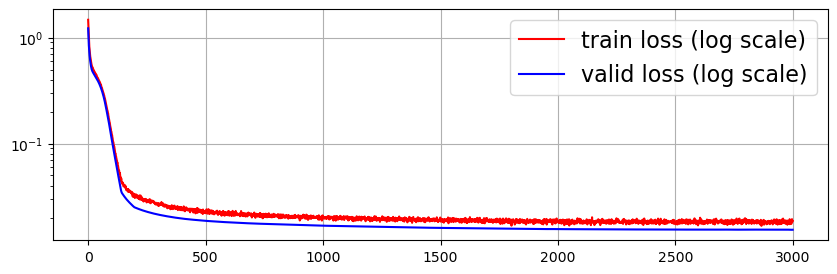

In [13]:
# fig_trainloss = plt.figure(figsize=(10, 3))
# plt.plot(train_losses, color='r', label='train loss (log scale)')
# plt.plot(val_losses, color='b', label='valid loss (log scale)')
# plt.yscale("log")
# plt.grid(True)
# plt.legend(fontsize=16)
# if disp:
#     plt.show()
# if not (datasaver is None): datasaver.save_figure(fig_trainloss, "train&valid_loss")

In [35]:
path_to_data = os.path.join(projects_folder, "latent_circuit_inference", "data", "inferred_LCs", "BlockDMtanh",
                            "0.0011968_BlockDMtanh;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.002;maxiter=3000",
                            "9_0.9810267019249379_0.982110291149382_LC_BlockDMtanh",
                            "0.9810267019249379_0.982110291149382_LC_params.json")
net_params = json.load(open(path_to_data, "rb"))
net_params["bias_rec"] = np.zeros(np.array(net_params["W_rec"]).shape[0])
net_params["y_init"] = np.zeros(np.array(net_params["W_rec"]).shape[0])

In [36]:
# validate
RNN_valid = RNN_numpy(N=net_params["N"],
                      dt=net_params["dt"],
                      tau=net_params["tau"],
                      activation=numpify(activation),
                      W_inp=np.array(net_params["W_inp"]),
                      W_rec=np.array(net_params["W_rec"]),
                      W_out=np.array(net_params["W_out"]),
                      bias_rec=net_params["bias_rec"],
                      y_init=net_params["y_init"])

In [37]:
analyzer = PerformanceAnalyzer(RNN_valid)
score_function = lambda x, y: np.mean((x - y) ** 2)
input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
score = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid,
                                      mask, sigma_rec=sigma_rec, sigma_inp=sigma_inp)

In [38]:
print(f"MSE validation: {np.round(score, 5)}")
# if not (datasaver is None): datasaver.save_data(config_dict, "config.json")
# if not (datasaver is None): datasaver.save_data(best_net_params, f"params_{taskname}_{np.round(score, 5)}.pkl")

MSE validation: 0.07186


In [43]:
input_batch_valid.shape
RNN_valid.clear_history()
RNN_valid.run(input_batch_valid)
neural_traces = RNN_valid.get_history()
traces_data = {}
traces_data["inputs"] = input_batch_valid
traces_data["traces"] = neural_traces
traces_data["outputs"] = RNN_valid.get_output()
traces_data["net_params"] = net_params
path_to_traces = os.path.join(projects_folder, "latent_circuit_inference", "data", "inferred_LCs", "BlockDMtanh",
                            "0.0011968_BlockDMtanh;tanh;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.002;maxiter=3000",
                            "9_0.9810267019249379_0.982110291149382_LC_BlockDMtanh", 'neural_traces.pkl')
pickle.dump(traces_data, open(path_to_traces, "wb+"))

Plotting random trials


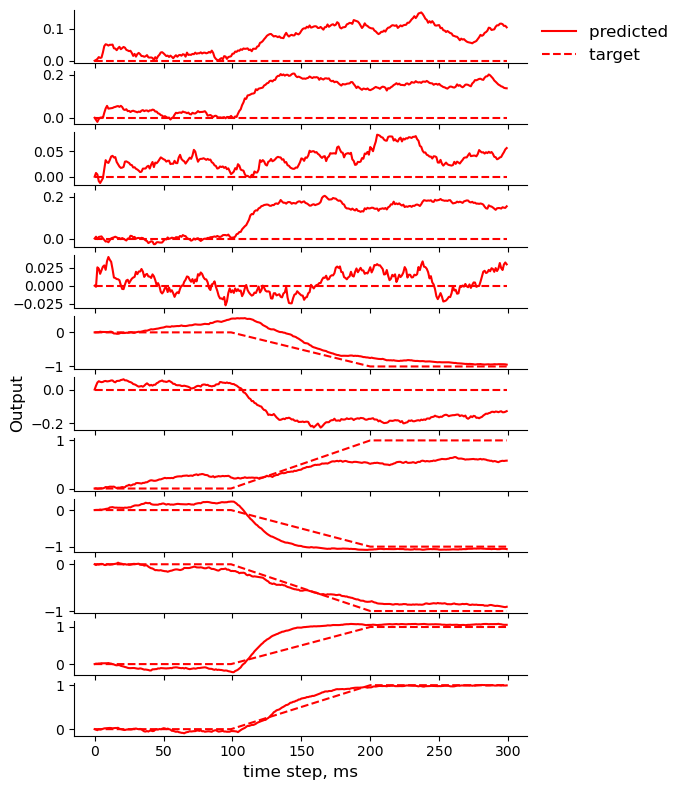

In [44]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 12)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]

fig_trials = analyzer.plot_trials(inputs, targets, mask, sigma_rec=0.03, sigma_inp=0.03)
if disp:
    plt.show()
if not (datasaver is None): datasaver.save_figure(fig_trials, "random_trials")

In [29]:
dsa = DynamicSystemAnalyzer(RNN_valid)
params = {"fun_tol" : 0.05,
          "diff_cutoff":1e-4,
          "sigma_init_guess":15,
          "patience":100,
          "stop_length":100,
          "mode":"approx"}
dsa.get_fixed_points(Input=np.array([0, 0]), **params)
dsa.get_fixed_points(Input=np.array([1, 0]), **params)

In [30]:
all_points = np.vstack([dsa.fp_data[str([0, 0])][type] for type in list(dsa.fp_data[str([0, 0])].keys())])
pca = PCA(n_components=1)
pca.fit(all_points)
P = np.zeros((RNN_valid.N, 2))
P[:, 0] = RNN_valid.W_out.flatten()
P[:, 1] = pca.components_.flatten()
# P = orthonormalize(P)

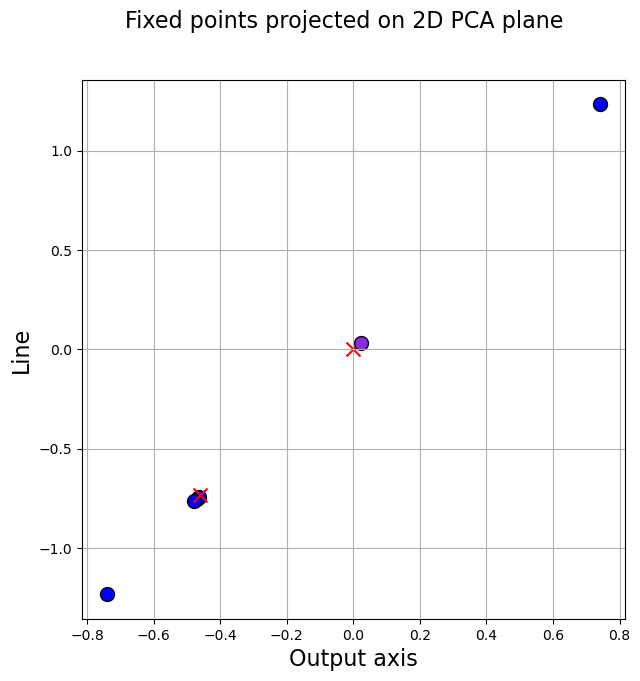

In [32]:
fig_fp = dsa.plot_fixed_points(projection='2D', P=P)
plt.xlabel("Output axis", fontsize=16)
plt.ylabel("Line", fontsize=16)
if disp:
    plt.show()